# Mouse clustering based on trial modes

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [5]:
path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'

filename = str(path + 'all_sequences_09-29-2025')
all_sequences = pd.read_parquet(filename)
all_sequences['session'] = all_sequences['sample'].str[:36]
# all_sequences = pd.read_parquet(seq_path+'all_sequences_09-22-2025')
# trial_modes = pd.read_parquet(path+'trial_clusters')
trial_modes = pd.read_parquet(path+'9_cluster_per_trial')
trial_modes = pd.read_parquet(path+'17_trial_waterclust')

In [6]:
def split_mice(all_sequences, n_parts):

    rng = np.random.default_rng() 
    all_sequences['mouse_part'] = np.zeros(len(all_sequences))
    for m, mouse in enumerate(all_sequences.mouse_name.unique()):
        mouse_df = all_sequences.loc[all_sequences['mouse_name']==mouse]
        n_trials = len(mouse_df)
        # Create shuffled labels for parts
        parts = np.tile(np.arange(n_parts), int(np.ceil(n_trials / n_parts)))[:n_trials]
        rng.shuffle(parts)  # Shuffle to randomize assignment
        # els.extend(parts)
        all_sequences.loc[all_sequences['mouse_name']==mouse, 'mouse_part'] = parts
    # Assign to new column
    all_sequences['mouse_part'] = all_sequences['mouse_part'].astype(str)
    # all_sequences = all_sequences.rename(columns={"sample": "trial_id"})
    all_sequences['mouse_part_sample'] = all_sequences[['mouse_name', 'mouse_part']].agg(' '.join, axis=1)
    split_mouse_df = all_sequences.copy()
    return split_mouse_df


def get_fraction_vectors(trial_clusters, target_length):

    all_sequences = pd.DataFrame(columns=['sample', 'mouse_name', 'trial_type', 'trial_cluster', 'bin'])
    for s, sample in enumerate(trial_clusters['sample'].unique()):

        # Get session data and order trials
        session_data = trial_clusters.loc[trial_clusters['sample']==sample]
        session_data = session_data[['sample', 'mouse_name', 'trial_id', 'trial_type', 'trial_cluster']].drop_duplicates()
        session_data['trial_id'] = session_data['trial_id'].astype(float)
        session_data = session_data.sort_values(by=['trial_id'])

        # Bin 
        n_trials = len(session_data)
        # Assign bin index: split into 10 parts
        bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
        session_data['bin'] = bin_indices
        
        all_sequences = pd.concat([all_sequences, session_data[['sample', 'mouse_name', 
                                                                'trial_type', 'trial_cluster', 'bin']]], ignore_index=True)

    fractions = all_sequences.groupby(['sample', 'mouse_name', 
                                    'bin'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index().sort_values(by=['bin', 'trial_cluster'])
    design_df = fractions.pivot(index=['mouse_name', 'sample'], columns=['bin', 'trial_cluster'], values='fraction').reset_index().fillna(0)

    return design_df


def binarize(design_df):

    epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']
    sequences_choice = np.vstack(design_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

    use_states = int(max(np.unique(use_sequences)))+1
    timesteps = np.shape(use_sequences)[1]
    binarized = np.zeros((np.shape(use_sequences)[0], timesteps*use_states))

    for t in range(timesteps):
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(use_states))
        encoded_arr = label_binarizer.transform(use_sequences[:, t])
        binarized[:, t*use_states:(t+1)*use_states] = encoded_arr

    return binarized


## Repeated samplings

In [7]:
n_parts = 2
repeats = 50
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import pdist, squareform
def jsd(u, v):
    return jensenshannon(u, v)

In [24]:
session_count = trial_modes[['mouse_name', 'session']].drop_duplicates().groupby(['mouse_name'])['session'].count().reset_index()
multi_sess_mice = session_count.loc[session_count['session']>2, 'mouse_name']
trial_modes = trial_modes.loc[trial_modes['mouse_name'].isin(multi_sess_mice)]

In [25]:
samplings_df = pd.DataFrame(columns=['repeat', 'matrix', 'distance_matrix'], index=range(repeats))

for r in range(repeats):
    print('Repeat %d of %d' % (r+1, repeats))  
        
    # Split data anew
    split_mouse_df = split_mice(trial_modes, 2)
    split_mouse_df = split_mouse_df.sort_values(by=['mouse_name'])
    split_mouse_df = split_mouse_df.loc[split_mouse_df['mouse_part']=='0.0']  # Use only one sample per session each time
    use_samples = split_mouse_df['sample']
    use_sequences = all_sequences.loc[all_sequences['sample'].isin(np.array(use_samples))]
    use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name'], 
                                 columns=['broader_label'], values='binned_sequence').reset_index().dropna()
    var_names = use_df.keys()[-4:]
        
    use_binarized = binarize(use_df)   
    mouse_syllables = pd.DataFrame(use_binarized)
    # mouse_syllables['session'] = use_df['session'].copy()
    mouse_syllables['mouse_name'] = use_df['mouse_name'].copy()
    # session_syllables = session_syllables.groupby(['session', 'mouse_name'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    mouse_syllables = mouse_syllables.groupby(['mouse_name'])[np.arange(0, 70, 1)].mean().reset_index()
    mouse_syllables = mouse_syllables.sort_values(by=['mouse_name'])

    # use_mat, named_labels, session_mouse_names, session_names = prepare_design_mat(mouse_syllables)
    use_mat = mouse_syllables.drop(columns='mouse_name')
    # use_mat = np.sqrt(use_mat)
    # pairwise_matrix = pairwise_distances(use_mat, metric='cosine')
    # pairwise_matrix = pairwise_distances(use_mat, metric='jsd')
    pairwise_matrix = squareform(pdist(use_mat, metric=jensenshannon))

    # Save results
    samplings_df.loc[r, 'repeat'] = r
    samplings_df.loc[r, 'matrix'] = np.array(use_mat)
    samplings_df.loc[r, 'distance_matrix'] = pairwise_matrix

Repeat 1 of 50
Repeat 2 of 50
Repeat 3 of 50
Repeat 4 of 50
Repeat 5 of 50
Repeat 6 of 50
Repeat 7 of 50
Repeat 8 of 50
Repeat 9 of 50
Repeat 10 of 50
Repeat 11 of 50
Repeat 12 of 50
Repeat 13 of 50
Repeat 14 of 50
Repeat 15 of 50
Repeat 16 of 50
Repeat 17 of 50
Repeat 18 of 50
Repeat 19 of 50
Repeat 20 of 50
Repeat 21 of 50
Repeat 22 of 50
Repeat 23 of 50
Repeat 24 of 50
Repeat 25 of 50
Repeat 26 of 50
Repeat 27 of 50
Repeat 28 of 50
Repeat 29 of 50
Repeat 30 of 50
Repeat 31 of 50
Repeat 32 of 50
Repeat 33 of 50
Repeat 34 of 50
Repeat 35 of 50
Repeat 36 of 50
Repeat 37 of 50
Repeat 38 of 50
Repeat 39 of 50
Repeat 40 of 50
Repeat 41 of 50
Repeat 42 of 50
Repeat 43 of 50
Repeat 44 of 50
Repeat 45 of 50
Repeat 46 of 50
Repeat 47 of 50
Repeat 48 of 50
Repeat 49 of 50
Repeat 50 of 50


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53471/678293703.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_map=plt.cm.get_cmap('Greys')


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40')])

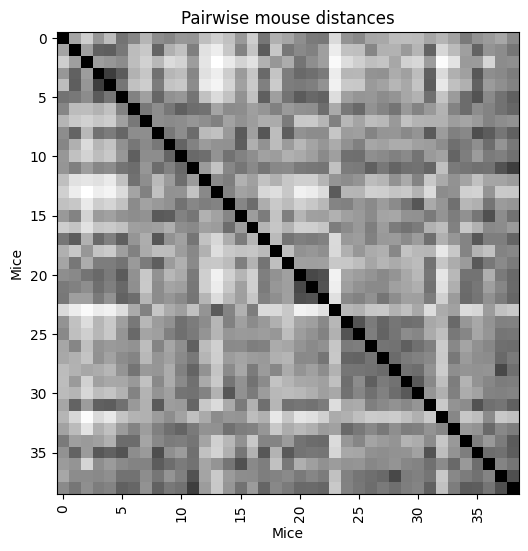

In [26]:
# fig, ax = plt.subplots(figsize=[20, 15])
orig_map=plt.cm.get_cmap('Greys')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
fig, ax = plt.subplots(figsize=[10, 6])
plt.imshow(np.mean(list(samplings_df['distance_matrix']), axis=0), cmap=reversed_map)
plt.xlabel('Mice')
plt.ylabel('Mice')
plt.title('Pairwise mouse distances')

mouse_numbers = pd.factorize(mouse_syllables['mouse_name'])[0]
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

# plt.xlim([np.shape(samplings_df['distance_matrix'])[0], 0])
# plt.ylim([0, np.shape(samplings_df['distance_matrix'])[0]])

## Cluster each repeat and build consensus matrix

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53471/2677081738.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53471/2677081738.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step 

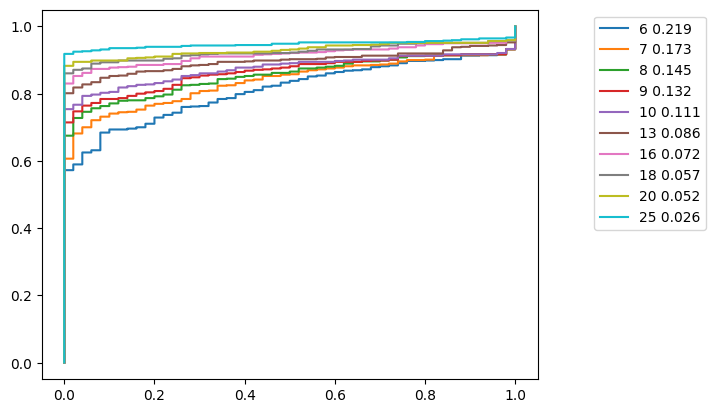

In [29]:
k = 100

K = [6, 7, 8, 9, 10, 13, 16, 18, 20, 25]
# K = [2, 3, 4, 5, 6, 7, 8, 9, 10]
all_ks = pd.DataFrame()

samplings_df['k'] = samplings_df['repeat'] * np.nan
samplings_df['clusters'] = samplings_df['repeat'] * np.nan

for i, k in enumerate(K):
    
    samplings_df['k'] = k
    samplings_df['clusters'] = samplings_df['repeat'] * np.nan
    n_samples, _ = pairwise_matrix.shape
    consensus_matrix = np.zeros((n_samples, n_samples))

    for r in range(repeats):
        pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
        linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
        # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
        # plt.show()

        # clusterer = hdbscan.HDBSCAN(min_cluster_size=k)
        # clusters = clusterer.fit_predict(pairwise_matrix)

        clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')

        # kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(pairwise_matrix)
        # # kmeans.labels_
        # clusters = kmeans.predict(pairwise_matrix)

        samplings_df['clusters'][r] = clusters 
        

        for i in range(n_samples):
            for j in range(i, n_samples):
                if clusters[i] == clusters[j]:
                    consensus_matrix[i, j] += 1
                    if i != j:
                        consensus_matrix[j, i] += 1  # symmetry
                            
    # Normalize to [0, 1]
    consensus_matrix /= repeats

    # Save
    if i == 0:
        all_ks = samplings_df
    else:
        all_ks = pd.concat([all_ks, samplings_df]) 

    # e = ECDF(consensus_matrix)
    e = ECDF(np.ravel(consensus_matrix))
    low_index = np.where(e.x>.1)[0][0]
    high_index = np.where(e.x<0.9)[0][-1]
    PAC = e.y[high_index] - e.y[low_index]
    # plt.step(e.x[::10], e.y[::10], label=str(str(k)+' '+str(PAC))) # color=palette[i],
    plt.step(e.x, e.y, label=str(str(k)+' '+str(np.round(PAC, 3)))) # color=palette[i],
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()



# Run with final k

In [38]:
k = 16
samplings_df['k'] = k
samplings_df['clusters'] = samplings_df['repeat'] * np.nan
n_samples, _ = pairwise_matrix.shape
consensus_matrix = np.zeros((n_samples, n_samples))

for r in range(repeats):
    pairwise_matrix = list(samplings_df.loc[samplings_df['repeat']==r, 'distance_matrix'])[0]
    linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
    # _ = plot_dendrogram(pairwise_matrix, title="Hierarchical Clustering")
    # plt.show()

    # import hdbscan
    
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=k)
    # clusters = clusterer.fit_predict(pairwise_matrix)

    clusters = fcluster(linkage_matrix, t=k, criterion='maxclust')
    samplings_df['clusters'][r] = clusters 

    for i in range(n_samples):
        for j in range(i, n_samples):
            if clusters[i] == clusters[j]:
                consensus_matrix[i, j] += 1
                if i != j:
                    consensus_matrix[j, i] += 1  # symmetry
                        
# Normalize to [0, 1]
consensus_matrix /= repeats

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53471/670599777.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(pairwise_matrix, method='average', metric='cosine')
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_53471/670599777.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40')])

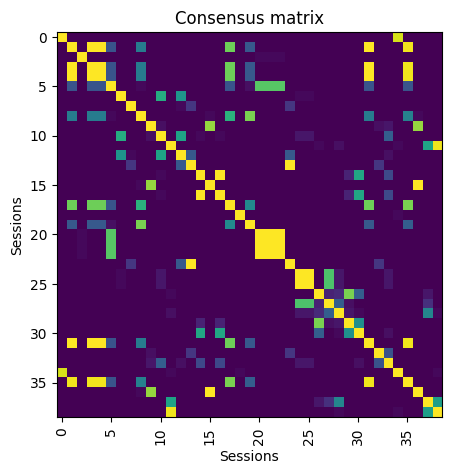

In [39]:
fig, ax = plt.subplots(figsize=[6, 5])
plt.imshow(consensus_matrix)
plt.xlabel('Sessions')
plt.ylabel('Sessions')
plt.title('Consensus matrix')

mouse_numbers = pd.factorize(mouse_syllables['mouse_name'])[0]
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)


In [40]:
# Associate clusters with unsplit data; attention to sorting!!
use_sequences = all_sequences.copy()
use_df = use_sequences.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='binned_sequence').reset_index().dropna()
var_names = use_df.keys()[-4:]
    
use_binarized = binarize(use_df)
full_mouse_syllables = pd.DataFrame(use_binarized)
# full_session_syllables['session'] = np.array(use_df['session'])
full_mouse_syllables['mouse_name'] = np.array(use_df['mouse_name'])
full_mouse_syllables = full_mouse_syllables.groupby(['mouse_name'])[np.arange(0, np.shape(use_binarized)[1], 1)].mean().reset_index()
full_mouse_syllables = full_mouse_syllables.sort_values(by=['mouse_name'])

In [41]:
import numpy as np
from collections import Counter

def reassign_small_clusters(labels, dist_matrix, min_size=5):
    """
    Reassigns clusters with fewer than `min_size` items
    to the nearest cluster based on average pairwise distance.
    
    Parameters
    ----------
    labels : array-like, shape (n_samples,)
        Cluster labels (ints)
    dist_matrix : ndarray, shape (n_samples, n_samples)
        Symmetric pairwise distance matrix
    min_size : int
        Minimum allowed cluster size

    Returns
    -------
    new_labels : np.ndarray
        Updated cluster labels
    """
    labels = np.array(labels).copy()
    unique = np.unique(labels)
    counts = Counter(labels)

    # Identify small clusters
    small_clusters = [c for c in unique if counts[c] < min_size]
    if not small_clusters:
        return labels  # nothing to do

    large_clusters = [c for c in unique if counts[c] >= min_size]

    for sc in small_clusters:
        idx_sc = np.where(labels == sc)[0]

        # Compute mean distance from each small-cluster item
        # to each large cluster
        best_target = None
        best_dist = np.inf

        for lc in large_clusters:
            idx_lc = np.where(labels == lc)[0]
            # average distance small ↔ large cluster
            dist = dist_matrix[np.ix_(idx_sc, idx_lc)].mean()

            if dist < best_dist:
                best_dist = dist
                best_target = lc

        # Reassign small cluster to nearest large cluster
        labels[idx_sc] = best_target

    return labels


ValueError: Dimensions of Z and labels must be consistent.

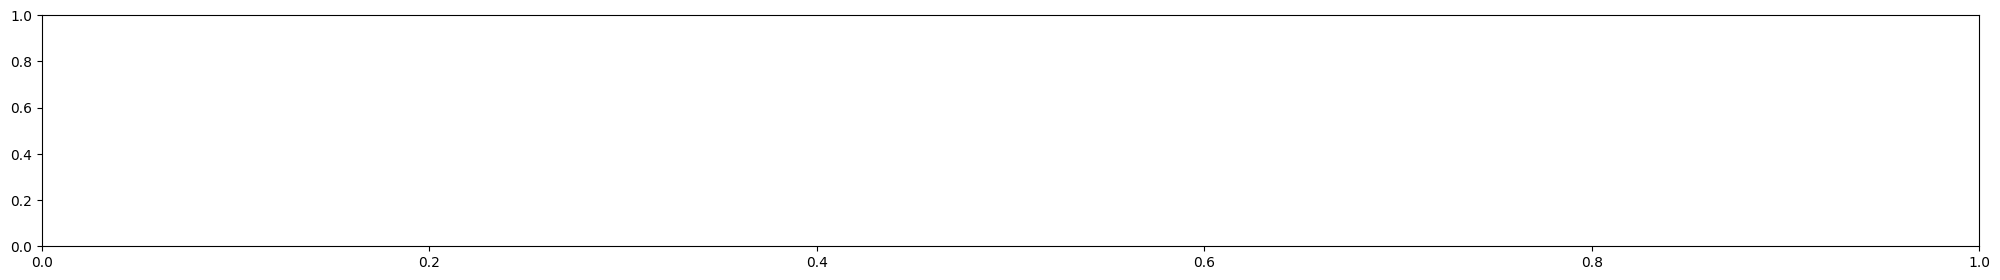

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram
# Perform clustering
from scipy.spatial.distance import squareform
D = 1 - consensus_matrix  # distance = 1 - similarity
D = consensus_matrix
Z = linkage(consensus_matrix, method='average')  #, metric='cosine')  # You can also try 'complete', 'ward', etc.

from scipy.cluster.hierarchy import ward, fcluster
# final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = fcluster(Z, t=k, criterion='maxclust')
final_clusters = final_clusters - 1    
# Suppose we have labels from hierarchical clustering
# labels = fcluster(Z, t=5, criterion='maxclust')
# dist_matrix is your pairwise JSD / cosine / Euclidean matrix
final_clusters = reassign_small_clusters(final_clusters, consensus_matrix, min_size=4)

# print("Before:", Counter(labels))
# print("After:", Counter(new_labels))

mouse_labels = np.array(full_mouse_syllables['mouse_name'])#.unique()
# design_df['session_cluster'] = clusters 

# Plot dendrogram
fig, ax = plt.subplots(figsize=(25, 3))

# Define colors for clusters
cmap = plt.get_cmap(sns.color_palette("tab10", k, as_cmap=True))
# cmap = plt.get_cmap(sns.color_palette(k, as_cmap=True))
colors = [cmap(i % cmap.N) for i in range(k)]
cluster_colors = {i: colors[i] for i in range(k)}

# Plot dendrogram with colored labels
dendro = dendrogram(Z, labels=mouse_labels, leaf_font_size=10, ax=ax, leaf_rotation=45)

# Apply colors to tick labels
x_labels = ax.get_xmajorticklabels()
counter = 0
for lbl in x_labels:
    mouse_id = lbl.get_text()
    cluster_id = final_clusters[mouse_labels==mouse_id][0]
    lbl.set_color(cluster_colors[cluster_id])

plt.title("Hierarchical Clustering of Mice")
plt.ylabel("Distance")
plt.tight_layout()

plt.show()

(array([19.,  0., 13.,  0., 10., 11.,  0.,  7.,  5.,  5.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

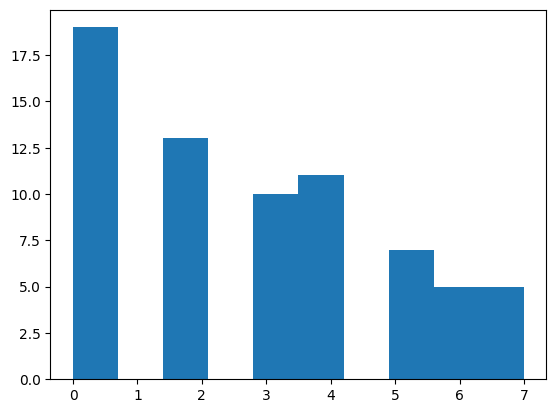

In [23]:
plt.hist(final_clusters)

In [246]:
full_mouse_syllables['mouse_cluster'] = final_clusters.copy()

## Save

In [247]:
# data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# filename = "6_cluster_per_mouse_trial"
# full_mouse_syllables.to_parquet(data_path+filename)  

## Visualize

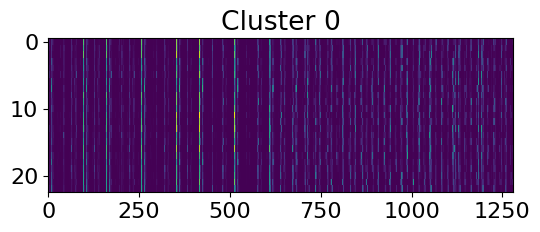

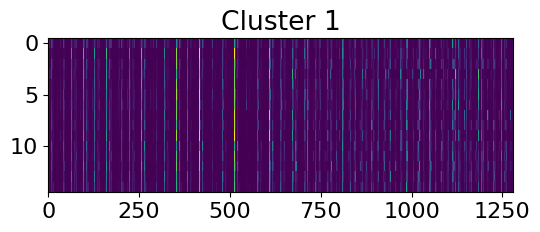

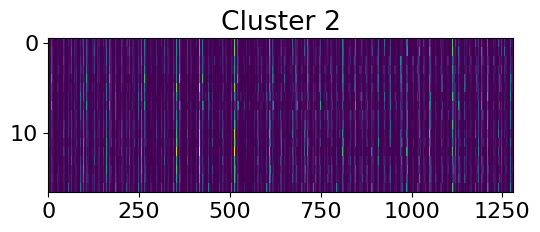

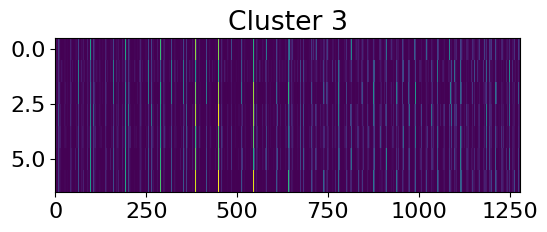

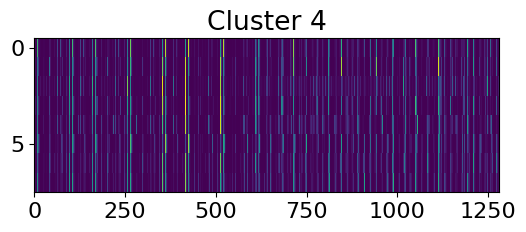

In [248]:
for c, cluster in enumerate(np.unique(final_clusters)):
    indices = np.where(final_clusters==cluster)[0]
    data = np.array(full_mouse_syllables[np.arange(0,np.shape(use_binarized)[1], 1)])[indices, :]
    plt.figure(figsize=(6, 2))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    # plt.xticks(np.arange(0, np.shape(final_matrix)[1], 160), np.arange(0, np.shape(final_matrix)[1], 160))
    plt.title('Cluster ' + str(c))
    plt.show()

## Plot 

In [249]:
trial_modes = pd.read_parquet(path+'9_cluster_per_trial')
trial_modes.keys()
trial_modes['trial_id'] = trial_modes['sample'].str.split().str[1:2].str.join('')
trial_modes = trial_modes.merge(full_mouse_syllables[['mouse_name', 'mouse_cluster']].drop_duplicates(), on='mouse_name')


In [250]:
plot = False
target_length = 3

plot_sequences = pd.DataFrame(columns=['mouse_name', 'mouse_cluster', 'sample', 'trial_cluster', 'bin'])
# for s, session_part in enumerate(trial_modes['sample'].unique()):

# Get session data and order trials
# session_data = trial_modes.loc[trial_modes['sample']==session_part]
session_data = trial_modes[['mouse_name', 'trial_id', 'trial_type', 'sample', 'trial_cluster', 'mouse_cluster']].drop_duplicates()
session_data['trial_id'] = session_data['trial_id'].astype(float)
session_data = session_data.sort_values(by=['trial_id'])

# Bin 
n_trials = len(session_data)
# Assign bin index: split into 10 parts
bin_indices = pd.qcut(np.arange(n_trials), q=target_length, labels=False)
session_data['bin'] = bin_indices

# if plot == True:
#     states_to_append = np.arange(0, num_states)
#     for i in range(100):
#         if df_grouped['broader_label'][i] == 'Choice':
#             plot_binned_sequence(df_grouped, i, states_to_append)    
plot_sequences = pd.concat([plot_sequences, session_data[['mouse_name', 'mouse_cluster', 'sample',
                                                        'trial_cluster', 'bin']]], ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


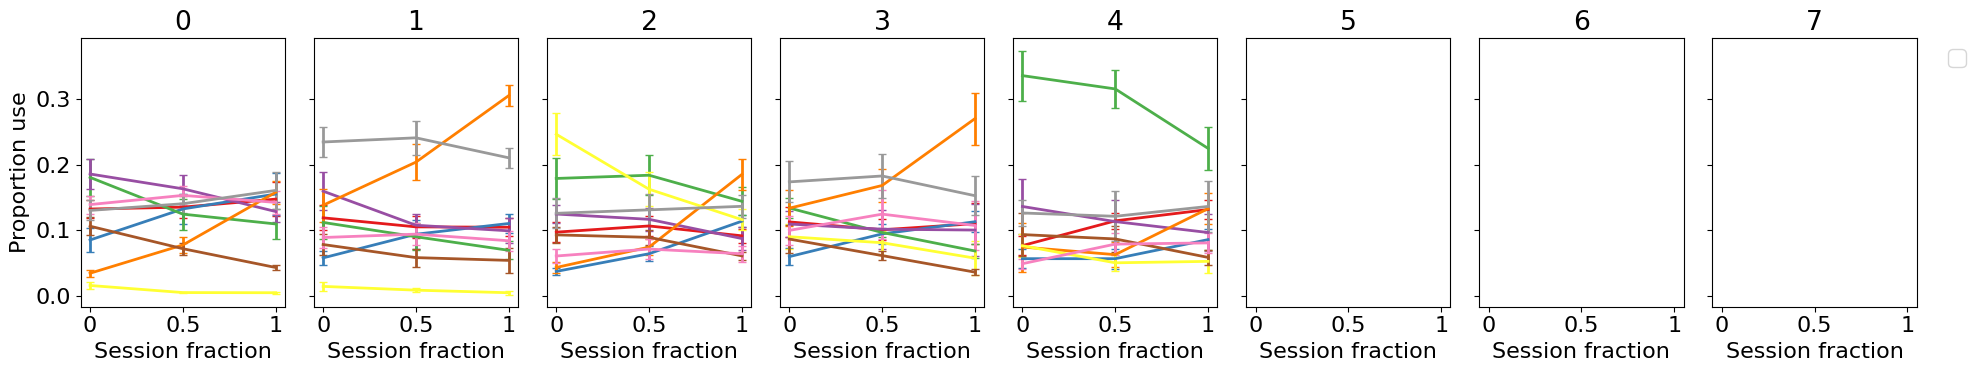

In [251]:
# palette = sns.color_palette("dark:salmon_r", 7, as_cmap=False)
palette = sns.color_palette("Set1", 10, as_cmap=False)

from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette(palette).as_hex())


fractions = plot_sequences.groupby(['mouse_name', 'mouse_cluster', 
                                    'bin'])['trial_cluster'].value_counts(normalize=True).rename('fraction').reset_index()
fig, axs = plt.subplots(1, 8, sharex=True, sharey=True, figsize=(20, 4))

for phenotype in [0, 1, 2, 3, 4, 5, 6, 7]:

    # Group by bin and cluster, and compute mean and SEM
    summary = fractions.loc[fractions['mouse_cluster']==phenotype].groupby(['bin', 
                                                                           'trial_cluster'])['fraction'].agg(['mean', 'sem']).reset_index()
    # Ensure correct types
    summary['bin'] = summary['bin'].astype(float)
    summary['trial_cluster'] = summary['trial_cluster'].astype(float)

    # Prepare plot
    plt.rc('font', size=16)

    clusters = sorted(summary['trial_cluster'].unique())

    # Plot one line with error bars for each cluster
    for i, cluster in enumerate(clusters):
        cluster_data = summary[summary['trial_cluster'] == cluster]
        axs[phenotype].errorbar(
            cluster_data['bin'], 
            cluster_data['mean'], 
            yerr=cluster_data['sem'], 
            label=f'Trial mode {int(cluster)}',
            color=my_cmap(i),
            capsize=3,
            linewidth=2
        )

    # Customize axes
    # axs[phenotype].set_xticks([0, 1, 2, 3, 4], [0, .25, .5, .75, 1])
    axs[phenotype].set_xticks([0, 1, 2], [0, .5, 1])
    # axs[phenotype].set_xticks(sorted(fractions['bin'].unique()))
    # axs[phenotype].set_xticklabels([str(int(b)) for b in sorted(fractions['bin'].unique())])
    axs[phenotype].set_xlabel('Session fraction')
    axs[phenotype].set_title(str(phenotype))
axs[0].set_ylabel('Proportion use')
axs[7].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()